In [198]:
import sys
sys.path.append('..')

from spyral.core.constants import QBRHO_2_P
from spyral.core.run_stacks import form_run_string

from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.target import GasTarget, load_target
from spyral_utils.plot import Histogrammer
from analysis_utils import breit_wigner_shape, detector_responsenew, exp_line, sqrtfit

from pathlib import Path
from scipy.constants import physical_constants, torr
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import vector
import lmfit 

%matplotlib widget

In [199]:
# Load config
workspace_path = Path("/Volumes/e20009/e20009_analysis")
solver_result_path = workspace_path / "InterpSolver"
target_material_path = Path("/Users/attpc/Desktop/e20009_analysis/e20009_analysis/e20009_parameters/e20009_target.json")
beam_events_path = workspace_path / "beam_events"

# Run number range (inclusive)
run_min = 108
run_max = 366

# The nucleus we observe (the one fitted)
ejectile_z = 1
ejectile_a = 1

# The incoming nucleus (the beam)
projectile_z = 4
projectile_a = 10

# The target nucleus
target_z = 1
target_a = 2

residual_z = target_z + projectile_z - ejectile_z
residual_a = target_a + projectile_a - ejectile_a

if residual_z < 0:
    raise Exception(f"Illegal nuclei! Residual Z: {residual_z}")
if residual_a < 1:
    raise Exception(f"Illegal nuclei! Residual A: {residual_a}")

In [200]:
# Setup nuclear data objects
nuclear_map = NuclearDataMap()

target_material = load_target(target_material_path, nuclear_map)
if not isinstance(target_material, GasTarget):
    print('Target error!')

ejectile = nuclear_map.get_data(ejectile_z, ejectile_a)
projectile = nuclear_map.get_data(projectile_z, projectile_a)
target = nuclear_map.get_data(target_z, target_a)
residual = nuclear_map.get_data(residual_z, residual_a)

In [201]:
# Define parameters used for analysis
proj_energy_start = 93.0 #Units of MeV. Initial beam energy

min_z = 0.005    # Units of meters. Minimum z value of vertex
max_z = 0.96    # Units of meters. Maximum z value of vertex

min_cm = 0.0    # Units of degrees. Minimum center-of-mass scattering angle for events in excitation spectrum
max_cm = 38.0   # Units of degrees. Maximum center-of-mass scattering angle for events in excitation spectrum

ex_en_min = 3.1 # Units of MeV. Minimum excitation energy gate for angular distribution
ex_en_max = 3.7 # Units of MeV. Maximum excitation energy gate for angular distribution

redchi = 5.0e-5  # Events must have a reduced chi squared value less than this

In [202]:
# Define parameters used for finding the cross section
downscale_factor = 1000

ic_min_val = 450.0
ic_max_val = 850.0

boltzmann = physical_constants["Boltzmann constant"][0]    # Units of Joules / Kelvin
torr_2_pascal = torr    # Convert from torr to pascals
pressure = 600 # Units of Torr
temperature = 273.15    # Units of Kelvin, STP
stoich = 2 # Stoichiometry of gas

In [203]:
# Create histograms
# Note for histograms that the input upper edge is the maximum allowed value,
# ie if the upper edge is n then the last bin is inclusive on both sides [n-1, n]
grammer = Histogrammer()
grammer.add_hist2d('ke_theta', (360, 800), ((0.0, 180.0), (0.0, 40.0)))
grammer.add_hist2d('ke_phi', (360, 1600), ((0.0, 360.0), (0.0, 80.0)))
grammer.add_hist1d('ex',100, (-1.0, 4.0))
grammer.add_hist1d('chisq', 2000, (0.0, 1.0e-3))
grammer.add_hist1d("cm_polar", 90, (0.0, 180.0))
grammer.add_hist1d('beam_events_ic', 4095, (0.0, 4095.0))
grammer.add_hist1d('sim_lab_polar', 18, (0.0, 90.0))
grammer.add_hist2d('chi_polar', (180, 500), ((0.0, 180.0), (0.0, 10e-5)))
grammer.add_hist1d('z_vert', 1000, (-0.1, 1.1))

In [204]:
# Do analysis of events. Check the bin equalities are okay
kinetics = np.empty(0, float)
angles = np.empty(0, float)
chisq = np.empty(0, float)
target_vector = vector.array({"px": [0.0], "py": [0.0], "pz": [0.0], "E": [target.mass]})

for run in range(run_min, run_max+1):
    df = None
    try:
        path = solver_result_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"
        df = pl.read_parquet(path)
    except Exception:
        continue

    # Apply gates to data
    df = (df.filter((pl.col('redchisq') < redchi)
                   & (pl.col("vertex_z") > min_z) 
                   & (pl.col("vertex_z") < max_z)
                   )
            .sort("polar", descending=True)
            .unique("event", keep="first")
    )

    # Construct the projectile vectors (beam)
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
        "px": np.zeros(len(projectile_ke)),
        "py": np.zeros(len(projectile_ke)),
        "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
        "E": projectile_ke + projectile.mass
    })

    # Construct the ejectile vectors (detected)
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
        "px": momentum * np.sin(polar) * np.cos(az),
        "py": momentum * np.sin(polar) * np.sin(az),
        "pz": momentum * np.cos(polar),
        "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
    })

    # Get reduced chi-squared information
    cs = df.select('redchisq').to_numpy().flatten()

    # Get vertex z position
    zvert=df.select('vertex_z').to_numpy().flatten()
    grammer.fill_hist1d('z_vert', zvert)

    # Do the kinematics
    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    # Calculate CM scattering angle 
    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    # Gate excitation spectrum on CM angle
    mask_ex = (np.deg2rad(min_cm) <= cm_polar) & (cm_polar < np.deg2rad(max_cm))    # Make note of asymmetric inequalites for binning!
    ex_energy_gated = ex_energy[mask_ex]

    # Select excited state to look at its angular distribution
    mask_cm = (ex_en_min <= ex_energy_gated) & (ex_energy_gated < ex_en_max)    # Make note of asymmetric inequalites for binning!
    cm_polar_gated = cm_polar[mask_ex]
    cm_polar_gated = cm_polar_gated[mask_cm]    # Doing the gates in this order ensures that the angular distribution is < max_cm

    # Fill histograms and arrays
    grammer.fill_hist2d('ke_theta', np.rad2deg(polar), kinetic_energy)
    grammer.fill_hist2d('ke_phi', np.rad2deg(az), kinetic_energy)
    grammer.fill_hist1d('ex', ex_energy_gated)
    grammer.fill_hist1d("cm_polar", np.rad2deg(cm_polar_gated))
    grammer.fill_hist1d("chisq", cs)
    grammer.fill_hist2d('chi_polar', np.rad2deg(polar), cs)
    kinetics = np.append(kinetics, kinetic_energy)
    angles = np.append(angles, np.rad2deg(polar))
    chisq = np.append(chisq, cs)

print(f"Median chisq: {np.median(chisq)}")

Median chisq: 8.965203069450383e-06


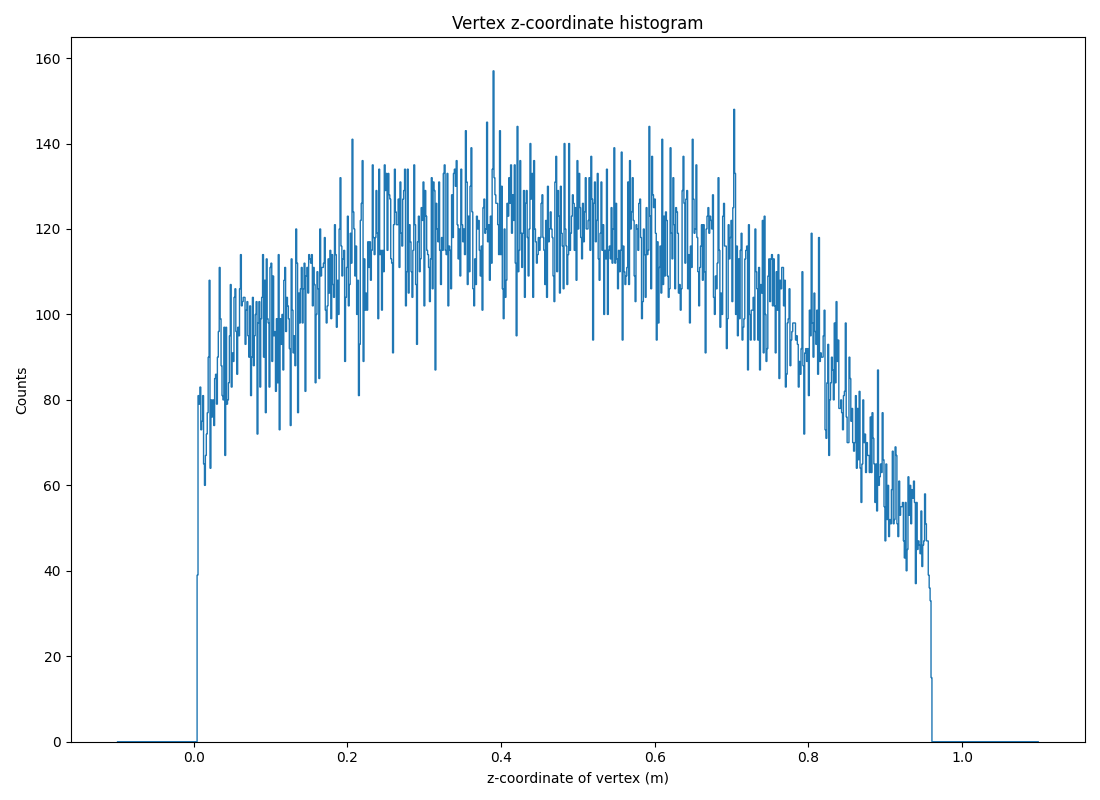

In [205]:
# Plot residual excitation energy spectrum
vertz = grammer.get_hist1d("z_vert")
fig, ax = plt.subplots(1,1)
ax.stairs(vertz.counts, edges=vertz.bins)
ax.set_title(f"Vertex z-coordinate histogram")
ax.set_xlabel("z-coordinate of vertex (m)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [206]:
# Perform analysis of beam events
for run in range(run_min, run_max+1):
    df = None
    try:
        path = beam_events_path / f"{form_run_string(run)}.parquet"
        df = pl.read_parquet(path)
    except Exception:
        continue
    
    # # Code for finding beam events where no IC peak was found
    # df = df.filter(pl.col("ic_amplitude").list.len() == 0)
    # print(df)
    
    #ic_amp = df.select(pl.col('ic_amplitude').list.explode()).to_numpy().flatten()
    ic_amp = df.select(pl.col('ic_amplitude').list.get(0)).to_numpy().flatten()
    
    grammer.fill_hist1d('beam_events_ic', ic_amp)

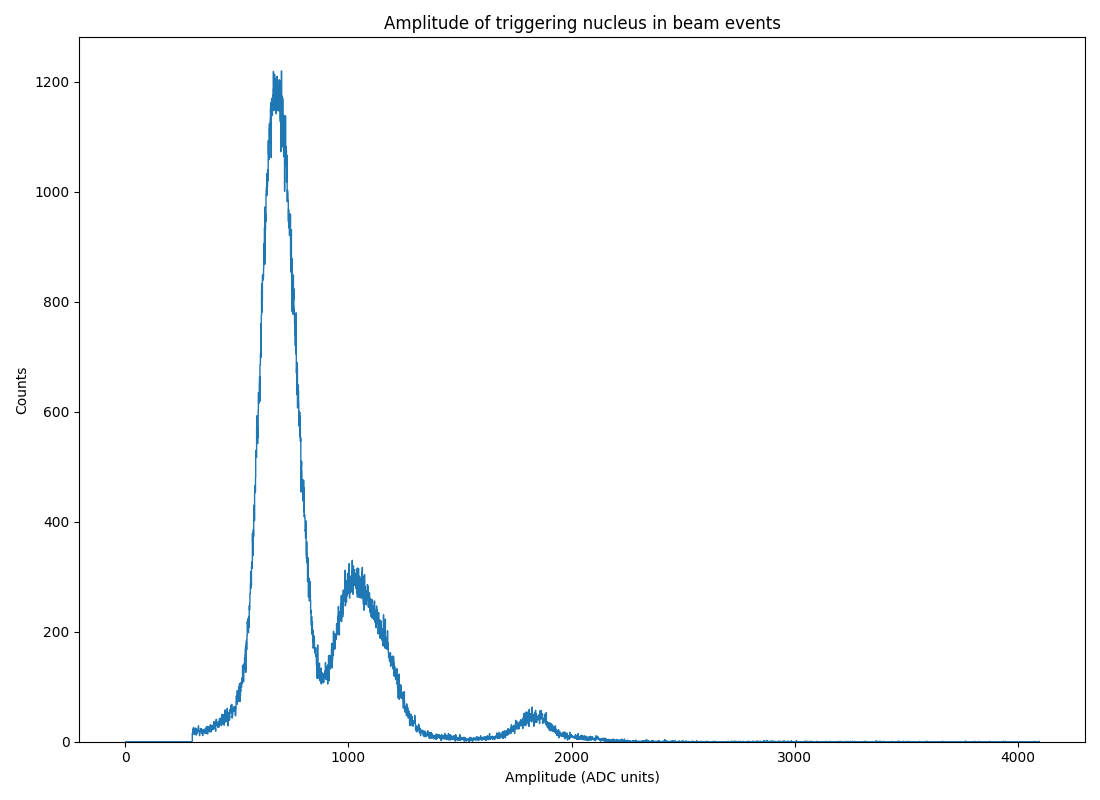

In [207]:
# Plot signal amplitude of beam particles in beam events
beam_events_ic = grammer.get_hist1d('beam_events_ic')
fig, ax = plt.subplots()
ax.stairs(beam_events_ic.counts, edges=beam_events_ic.bins)
ax.set_title('Amplitude of triggering nucleus in beam events')
ax.set_xlabel('Amplitude (ADC units)')
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [208]:
# # Perform analysis of simulated state
# sim_data = h5.File('/Volumes/e20009/h5new/run_0100.h5', "r")
# meta_group = sim_data.get("meta")
# meta_data = meta_group.get("meta")  # type: ignore
# min_event = int(meta_data[0])
# max_event = int(meta_data[2])

# input_lab_polar = []
# for event in range(min_event, max_event + 1):
#     input_group = sim_data.get('input')
#     event_input = input_group.get(f"evt{event}_input")
#     input_lab_polar.append(event_input[6])

# grammer.fill_hist1d('sim_lab_polar', np.asarray(input_lab_polar))

In [209]:
# Add states here!
proj_energy_stop = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, np.array([1.0]))[0] # Energy at far end of detector
print(f"Beam energy range: {proj_energy_start}-{proj_energy_stop} MeV")
residual_excitations = np.array([0.0, 1.78])

# Do the calculation in the center of mass
cm_angle_range = np.linspace(0., np.pi, 1000)
# Calculate envelope from range of beam energies
eject_kinematics = np.zeros((len(residual_excitations), len(cm_angle_range) * 2, 2))

# Upper limit (maximum beam energy)
beam_vec_max = vector.array({
    "px": [0.0],
    "py": [0.0],
    "pz": [np.sqrt(proj_energy_start * (proj_energy_start + 2.0 * projectile.mass))],
    "E": [proj_energy_start + projectile.mass]
})
parent_max = target_vector + beam_vec_max
parent_cm_max = parent_max.boostCM_of(parent_max)
for idx, ex in enumerate(residual_excitations):
    eject_e_cm_max = (ejectile.mass**2.0 - (residual.mass + ex)**2.0 + parent_cm_max.E**2.0) / (2.0 * parent_cm_max.E)
    eject_p_cm_max = np.sqrt(eject_e_cm_max**2.0 - ejectile.mass**2.0)
    eject_vec_cms_max = vector.array({
        "px": eject_p_cm_max * np.sin(cm_angle_range),
        "py": np.zeros(len(cm_angle_range)),
        "pz": eject_p_cm_max * np.cos(cm_angle_range),
        "E": np.full(len(cm_angle_range), eject_e_cm_max)
    })
    eject_vec_lab_max = eject_vec_cms_max.boost(parent_max)
    eject_kinematics[idx, :len(cm_angle_range), 0] = eject_vec_lab_max.theta
    eject_kinematics[idx, :len(cm_angle_range), 1] = eject_vec_lab_max.E - ejectile.mass

# Lower limit (minimum beam energy)
beam_vec_min = vector.array({
    "px": [0.0],
    "py": [0.0],
    "pz": [np.sqrt(proj_energy_stop * (proj_energy_stop + 2.0 * projectile.mass))],
    "E": [proj_energy_stop + projectile.mass]
})
parent_min = target_vector + beam_vec_min
parent_cm_min = parent_min.boostCM_of(parent_min)
for idx, ex in enumerate(residual_excitations):
    eject_e_cm_min = (ejectile.mass**2.0 - (residual.mass + ex)**2.0 + parent_cm_min.E**2.0) / (2.0 * parent_cm_min.E)
    eject_p_cm_min = np.sqrt(eject_e_cm_min**2.0 - ejectile.mass**2.0)
    eject_vec_cms_min = vector.array({
        "px": eject_p_cm_min * np.sin(cm_angle_range),
        "py": np.zeros(len(cm_angle_range)),
        "pz": eject_p_cm_min * np.cos(cm_angle_range),
        "E": np.full(len(cm_angle_range), eject_e_cm_min)
    })
    eject_vec_lab_min = eject_vec_cms_min.boost(parent_min)
    # Note that lower limit is "flipped". We plot the band as a polygon, so need to continue from large lab angles to small lab angles
    eject_kinematics[idx, len(cm_angle_range):, 0] = np.flip(eject_vec_lab_min.theta)
    eject_kinematics[idx, len(cm_angle_range):, 1] = np.flip(eject_vec_lab_min.E - ejectile.mass)

Beam energy range: 93.0-80.68084236544945 MeV


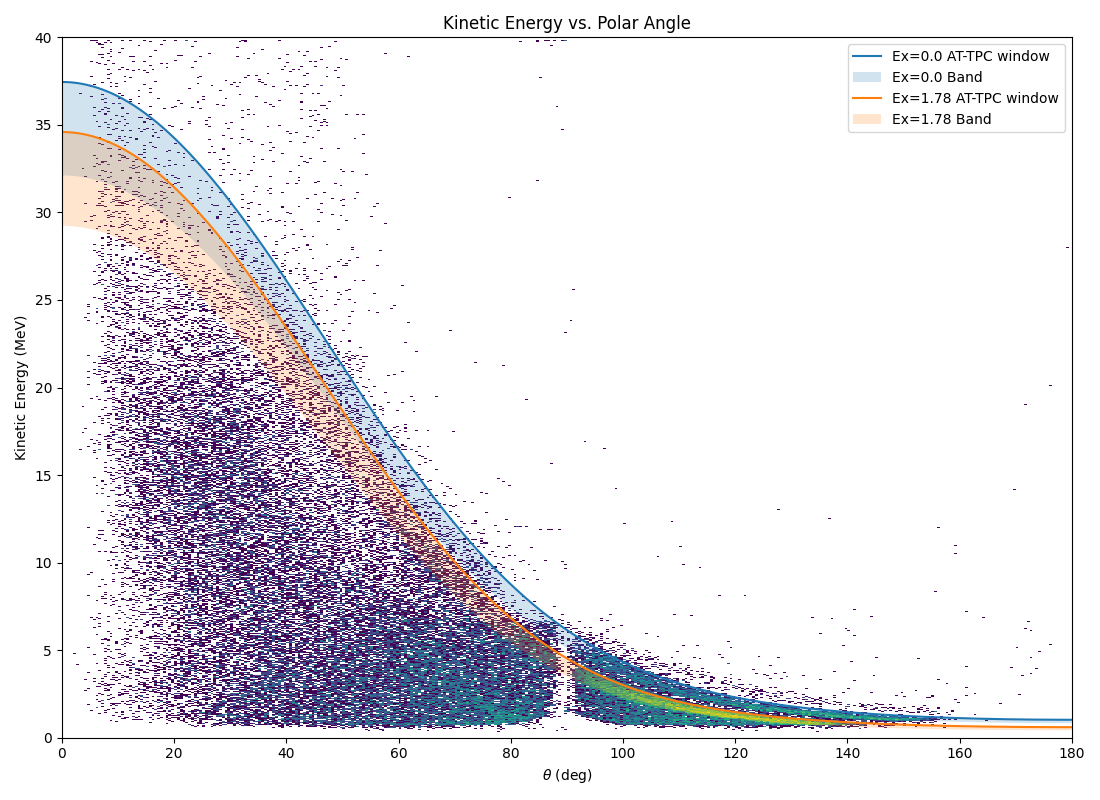

In [210]:
# Plot kinematics from data and compare with theoretical kinematics
ke_theta = grammer.get_hist2d("ke_theta")
ke_phi = grammer.get_hist2d("ke_phi")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(ke_theta.x_bins, ke_theta.y_bins, ke_theta.counts, norm="log")
ax.set_title("Kinetic Energy vs. Polar Angle")
ax.set_xlabel(r"$\theta$ (deg)")
ax.set_ylabel("Kinetic Energy (MeV)")
#fig.colorbar(mesh, ax=ax)
for idx, ex in enumerate(residual_excitations):
    ax.plot(np.rad2deg(eject_kinematics[idx, :len(cm_angle_range), 0]), eject_kinematics[idx, :len(cm_angle_range), 1], label=f"Ex={ex:02} AT-TPC window")
    # Fill idea thanks to D. Ramirez
    ax.fill(np.rad2deg(eject_kinematics[idx, :, 0]), eject_kinematics[idx, :, 1], label=f"Ex={ex:02} Band", alpha=0.2)
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
ax.legend()
fig.tight_layout()

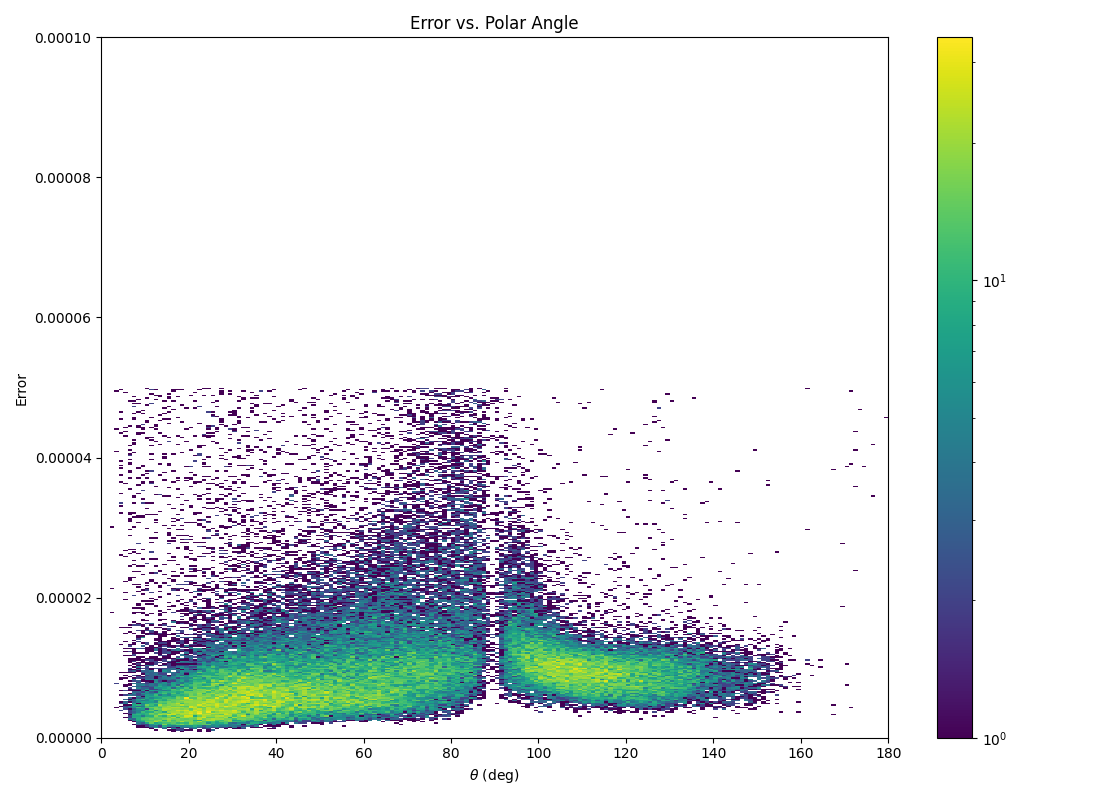

In [211]:
# Plot chi-squared vs lab polar angle
chi_polar = grammer.get_hist2d("chi_polar")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(chi_polar.x_bins, chi_polar.y_bins, chi_polar.counts, norm='log')
ax.set_title("Error vs. Polar Angle")
ax.set_xlabel(r"$\theta$ (deg)")
ax.set_ylabel("Error")
fig.colorbar(mesh, ax=ax)
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

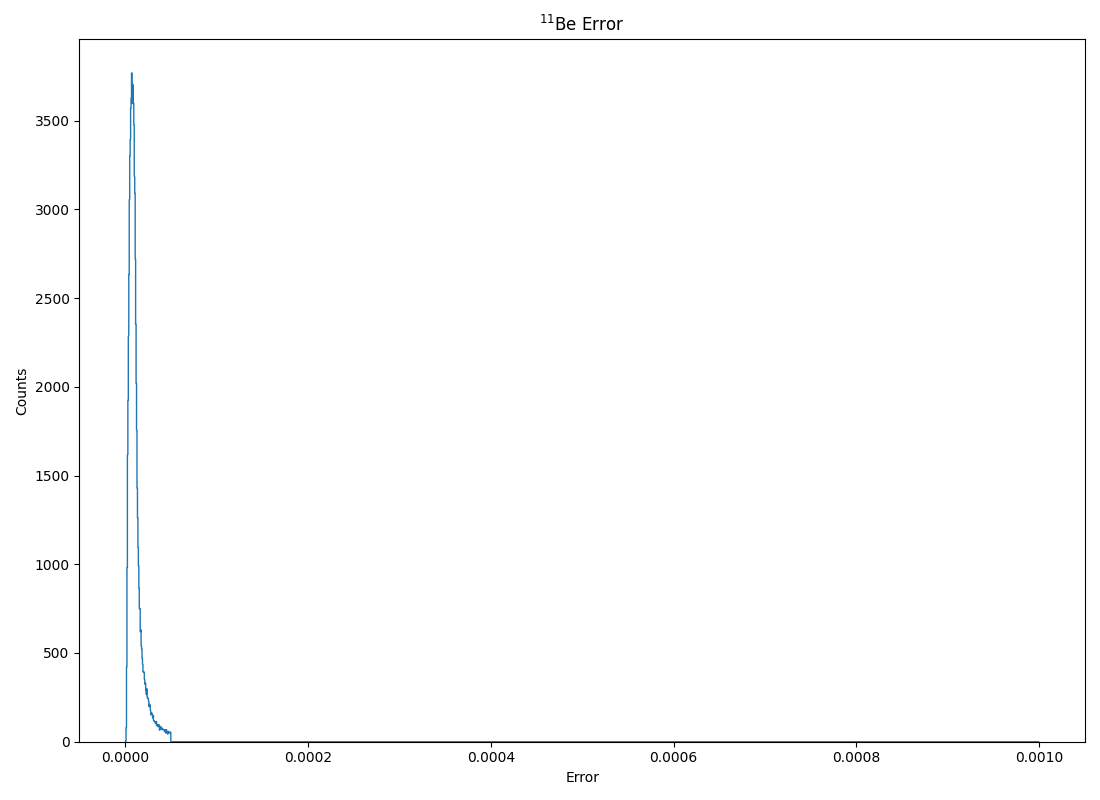

In [212]:
# Plot reduced chi-squared of fits to data
hist = grammer.get_hist1d("chisq")
fig, ax = plt.subplots(1,1)
ax.stairs(hist.counts, edges=hist.bins)
ax.set_title(f"{residual.get_latex_rep()} Error")
ax.set_xlabel("Error")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

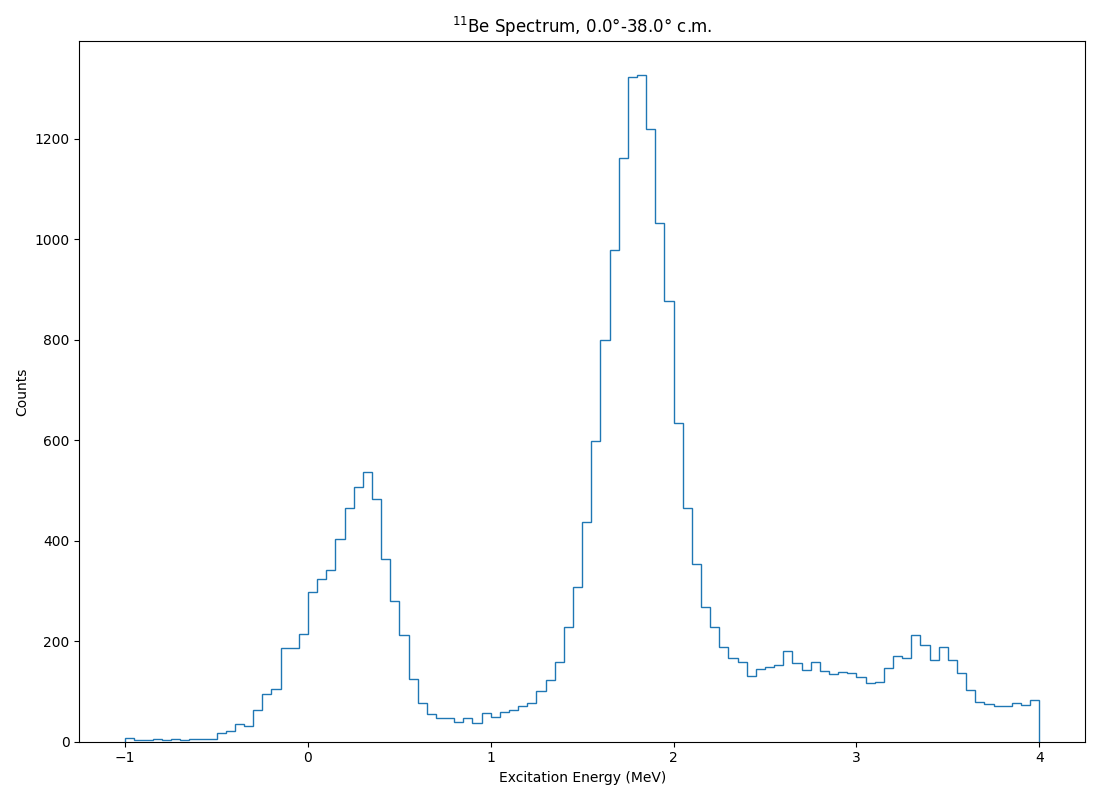

In [213]:
# Plot residual excitation energy spectrum
ex_hist = grammer.get_hist1d("ex")
fig, ax = plt.subplots(1,1)
ax.stairs(ex_hist.counts, edges=ex_hist.bins)
ax.set_title(f"{residual.get_latex_rep()} Spectrum, {min_cm}\N{DEGREE SIGN}-{max_cm}\N{DEGREE SIGN} c.m.")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

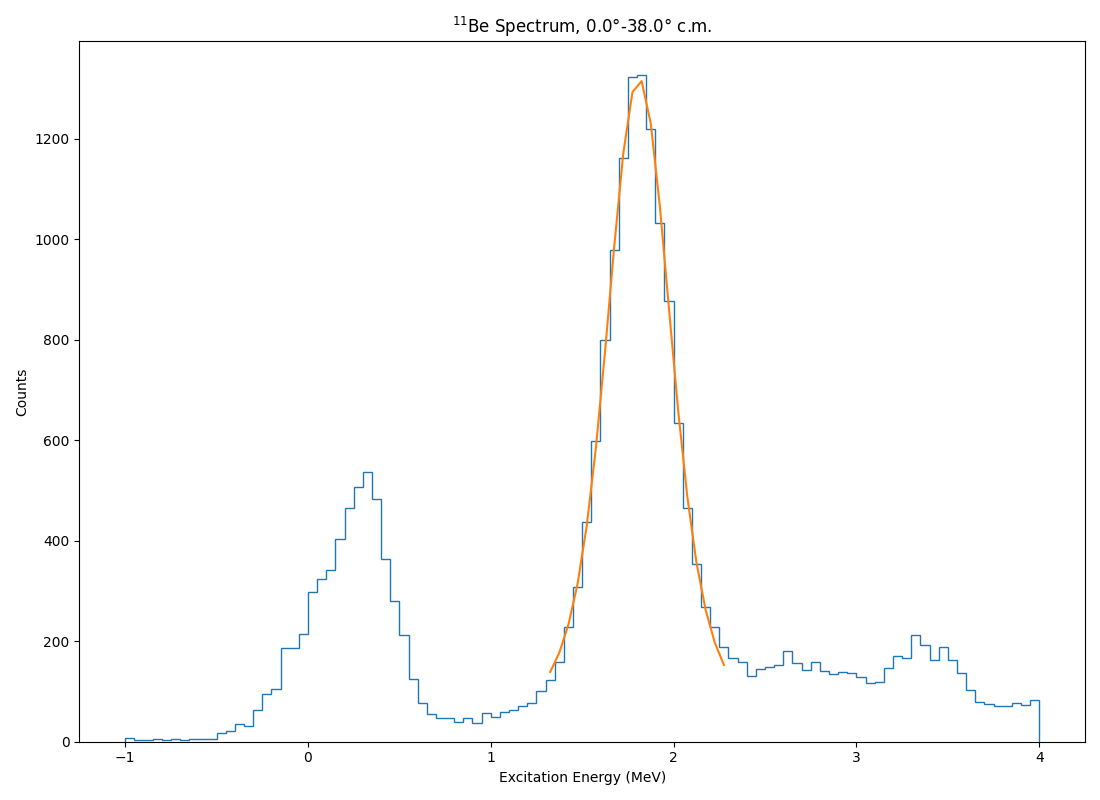

In [214]:
# Remove background from excitation spectrum
bin_width = grammer.get_hist1d("ex").bin_width
bins = grammer.get_hist1d("ex").bins
points = bins[:len(bins)-1]+bin_width/2
shape = breit_wigner_shape(points, 1.78, 0.2)
shape2 = detector_responsenew(points)
shape3 = exp_line(points, 1.78, 0.2, 1)


custom = lmfit.Model(exp_line)
params = lmfit.Parameters()
params.add("Ei", 1.78)
params.add("gamma", 0.2)
params.add("a", 500)

peak1_bins, peak1_counts = grammer.get_hist1d("ex").get_subrange((1.3, 2.3))
peak1_bins += 0.5*bin_width
peak1_weights = 1.0/np.sqrt(peak1_counts)
peak1_weights[peak1_counts == 0.0] = 1.0
pars = custom.fit(data=peak1_counts, points=peak1_bins, weights=peak1_weights, params=params)

gau = lmfit.models.VoigtModel()
pars = gau.guess(x=peak1_bins, data=peak1_counts, weights=peak1_weights)
real = gau.fit(params=pars, x=peak1_bins, data=peak1_counts, weights=peak1_weights)
# print(pars.fit_report())
#print(real.fit_report())
 

fig, ax = plt.subplots(1,1)
ax.set_title(f"{residual.get_latex_rep()} Spectrum, {min_cm}\N{DEGREE SIGN}-{max_cm}\N{DEGREE SIGN} c.m.")
ax.stairs(ex_hist.counts, edges=ex_hist.bins)
ax.plot(peak1_bins, real.best_fit)
# ax.plot(points, shape*10)
# ax.plot(points, shape2)
# ax.plot(points, shape3)
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [215]:
peak1 = lmfit.models.VoigtModel(prefix="peak1_")
peak1_bins, peak1_counts = ex_hist.get_subrange((-0.5, 0.5))
peak1_bins += 0.5 * ex_hist.bin_width
peak1_weights = 1.0/np.sqrt(peak1_counts)
peak1_weights[peak1_counts == 0.0] = 1.0
pars = peak1.guess(x=peak1_bins, data=peak1_counts, weights=peak1_weights)

peak2 = lmfit.models.VoigtModel(prefix="peak2_")
peak2_bins, peak2_counts = ex_hist.get_subrange((0.0, 0.7))
peak2_bins += 0.5 * ex_hist.bin_width
peak2_weights = 1.0/np.sqrt(peak2_counts)
peak2_weights[peak2_counts == 0.0] = 1.0
pars.update(peak2.guess(x=peak2_bins, data=peak2_counts, weights=peak2_weights))

peak3 = lmfit.models.VoigtModel(prefix="peak3_")
peak3_bins, peak3_counts = ex_hist.get_subrange((1.3, 2.2))
peak3_bins += 0.5 * ex_hist.bin_width
peak3_weights = 1.0/np.sqrt(peak3_counts)
peak3_weights[peak3_counts == 0.0] = 1.0
pars.update(peak3.guess(x=peak3_bins, data=peak3_counts, weights=peak3_weights))

peak4 = lmfit.models.VoigtModel(prefix="peak4_")
peak4_bins, peak4_counts = ex_hist.get_subrange((2.2, 3.0))
peak4_bins += 0.5 * ex_hist.bin_width
peak4_weights = 1.0/np.sqrt(peak4_counts)
peak4_weights[peak4_counts == 0.0] = 1.0
pars.update(peak4.guess(x=peak4_bins, data=peak4_counts, weights=peak4_weights))

peak5 = lmfit.models.LorentzianModel(prefix="peak5_")
peak5_bins, peak5_counts = ex_hist.get_subrange((3.1, 3.7))
peak5_bins += 0.5 * ex_hist.bin_width
peak5_weights = 1.0/np.sqrt(peak5_counts)
peak5_weights[peak5_counts == 0.0] = 1.0
pars.update(peak5.guess(x=peak5_bins, data=peak5_counts, weights=peak5_weights))

# bkgnd = lmfit.models.LinearModel(prefix="bkgnd_")
# bkgnd_bins, bkgnd_counts = ex_hist.get_subrange((-1.0, 4.0))
# bkgnd_bins += 0.5 * ex_hist.bin_width
# bkgnd_weights = 1.0/np.sqrt(bkgnd_counts)
# bkgnd_weights[bkgnd_counts == 0.0] = 1.0
# pars.update(bkgnd.guess(x=bkgnd_bins, data=bkgnd_counts))
# pars["bkgnd_slope"].min = 0.0

# custom = lmfit.Model(sqrtfit)
# bkgnd_bins, bkgnd_counts = ex_hist.get_subrange((0.5, 4.0))
# bkgnd_bins += 0.5 * ex_hist.bin_width
# bkgnd_weights = 1.0/np.sqrt(bkgnd_counts)
# bkgnd_weights[bkgnd_counts == 0.0] = 1.0
# pars.update(custom.make_params(A=1, c=-0.5, p=0.5, off=0))
# pars["p"].set(vary=False)

# total_fit = peak1 + peak2 + peak3 + peak4 + peak5 + bkgnd
total_fit = peak1 + peak2 + peak3 + peak4 + peak5 
total_bins, total_counts = ex_hist.get_subrange((-1.0, 4.0))
total_bins += 0.5 * ex_hist.bin_width
total_weights = 1.0/np.sqrt(total_counts)
total_weights[total_counts == 0.0] = 1.0
total_result = total_fit.fit(params=pars, x=total_bins, data=total_counts, weights=total_weights)
comps = total_result.eval_components(x=total_bins)
total_result

In [216]:
fig, ax = plt.subplots(1,1)
ax.stairs(ex_hist.counts, edges=ex_hist.bins, label="Spectrum")
ax.plot(total_bins, total_result.best_fit, label="Total Fit")
# ax.plot(total_bins, comps["peak1_"], label="peak1")
# ax.plot(total_bins, comps["peak2_"], label="peak2")
# ax.plot(total_bins, comps["peak3_"], label="peak3")
# ax.plot(total_bins, comps["peak4_"], label="peak4")
# ax.plot(total_bins, comps["peak5_"], label="peak5")
# ax.plot(total_bins, comps["bkgnd_"], label="bkgnd")
ax.set_title(f"{residual.get_latex_rep()} Spectrum Fit")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
ax.legend()
fig.tight_layout()

In [ ]:
# Calculate cross section
beam_rate, _, _ = beam_events_ic.stats_for_range((ic_min_val, ic_max_val))
beam_rate *= downscale_factor # Units of counts / time

length = max_z - min_z    # Units of meters
nuclei_areal_density = pressure * torr_2_pascal * length / boltzmann / temperature * stoich * 1.0e-31 # Units of target nuclei / millibarns

cm_hist = grammer.get_hist1d("cm_polar")
bins = cm_hist.bins
bin_width = cm_hist.bin_width

xs = cm_hist.counts / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / np.deg2rad(bin_width) / (2 * np.pi * beam_rate * nuclei_areal_density)   # Units of millibarns / steradians
err = np.sqrt(cm_hist.counts) / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / np.deg2rad(bin_width) / (2 * np.pi * beam_rate * nuclei_areal_density)

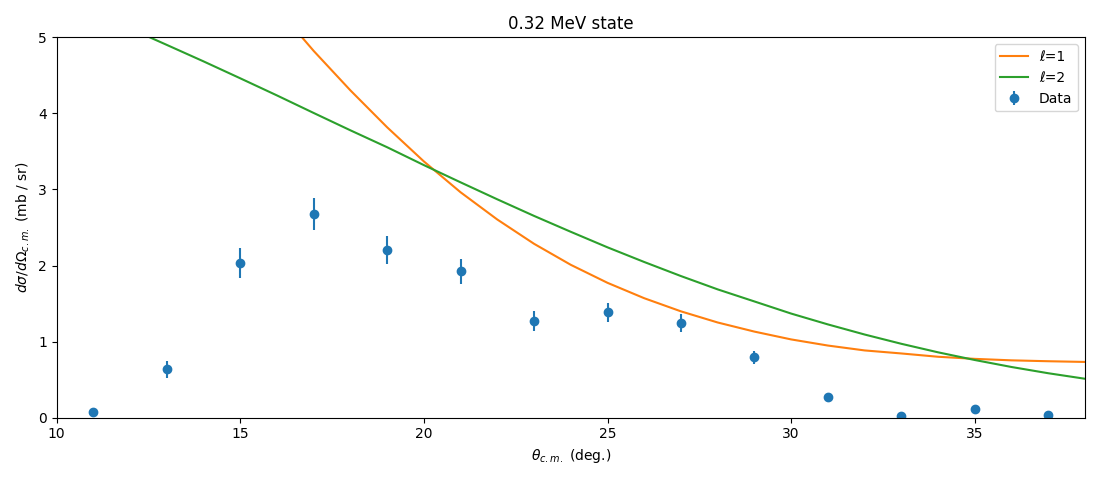

In [ ]:
# Plot angular distribution
#arb_xs = cm_hist.counts / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / bin_width
#err = np.sqrt(cm_hist.counts) / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / bin_width

# Ptolemy DWBA calculations
es3_l1 = pl.read_csv("/Volumes/e20009/ptolemy/11Be/3.4_mev/l1/beam_93mev.csv")
es3_l1_93 = es3_l1.to_dict(as_series=True)
es3_l2 = pl.read_csv("/Volumes/e20009/ptolemy/11Be/3.4_mev/l2/beam_93mev.csv")
es3_l2_93 = es3_l2.to_dict(as_series=True)
es2_l2 = pl.read_csv("/Volumes/e20009/ptolemy/11Be/1.78_mev/l2/beam_93mev.csv")
es2_l2_93 = es2_l2.to_dict(as_series=True)
es2_l1 = pl.read_csv("/Volumes/e20009/ptolemy/11Be/1.78_mev/l1/beam_93mev.csv")
es2_l1_93 = es2_l1.to_dict(as_series=True)

cm_hist = grammer.get_hist1d("cm_polar")
fig, ax = plt.subplots(1,1)
ax.errorbar(bins[:len(bins)-1]+bin_width/2, xs, yerr=err, fmt='o', label="Data")

ax.plot(es3_l1_93['cm_angle'],es3_l1_93['xs_mb']*0.16, label="ℓ=1")
ax.plot(es3_l2_93['cm_angle'],es3_l2_93['xs_mb']*0.08, label="ℓ=2")
# ax.plot(es2_l2_93['cm_angle'],es2_l2_93['xs_mb']*.29, label="ℓ=2")
# ax.plot(es2_l1_93['cm_angle'],es2_l1_93['xs_mb']*0.7, label="ℓ=1")

ax.set_title(f"{residual.get_latex_rep()} CM Scattering Angle")
ax.set_title("0.32 MeV state")
ax.set_xlabel(r"$\theta_{c.m.}$ (deg.)")
ax.set_ylabel(r"$d\sigma / d\Omega_{c.m.}$ (mb / sr)")
ax.legend()
plt.xlim(10,38)
plt.ylim(0,5)
fig.set_figwidth(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()